# OpenAI driven search of ICWA Legistation
This uses the Western Australian [Strata Titles Act 1985](https://www.legislation.wa.gov.au/legislation/statutes.nsf/main_mrtitle_938_homepage.html)


# Initialisation

Now load the .env file to get the API keys in a secure way. The path should be the full path to the .env file. If this work it returns `True`

In [ ]:
from dotenv import load_dotenv
load_dotenv() #get API keys

True

In [2]:
import docx
legislation_path = r'documents/Strata Titles Act 1985.docx'

# Prepare legislation

The legislation is a word document that can be readily manipulated using the `docx` module.

In [5]:
headings = tuple(set( paragraph.style.name for paragraph in docx.Document(legislation_path).paragraphs if paragraph.style.name.startswith("Heading")))
print(headings)
[":".join([paragraph.style.name, paragraph.text]) for paragraph in docx.Document(legislation_path).paragraphs if paragraph.style.name.startswith(headings)]

('Heading 2', 'Heading 3', 'Heading 5', 'Heading 4')


['Heading 2:Part\xa01\xa0—\xa0Preliminary',
 'Heading 5:1.\tShort title',
 'Heading 5:2.\tCommencement',
 'Heading 5:3.\tTerms used',
 'Heading 5:4.\tNotes and examples not part of Act',
 'Heading 5:5.\tAct binds Crown',
 'Heading 2:Part\xa02\xa0— Strata titles schemes',
 'Heading 5:6.\tLegislative framework',
 'Heading 5:7.\tStrata titles schemes',
 'Heading 5:8.\tFreehold schemes and leasehold schemes',
 'Heading 5:9.\tLots\xa0— strata schemes and surveystrata schemes',
 'Heading 5:10.\tCommon property',
 'Heading 5:11.\tSubdivision of land by strata titles scheme',
 'Heading 5:12.\tRegistration of strata titles scheme',
 'Heading 5:13.\tStrata titles',
 'Heading 5:14.\tStrata company',
 'Heading 2:Part\xa03\xa0—\xa0Planning and development',
 'Heading 3:Division\xa01\xa0—\xa0Planning approvals',
 'Heading 4:Subdivision\xa01 \xa0—\xa0Strata schemes',
 'Heading 5:15.\tSubdivision approval of strata scheme',
 'Heading 5:16.\tApplication of Planning and Development Act',
 'Heading 4:Sub


The document uses 3 levels of headings as follows
- Heading 2: The Parts of the legislation.
- Heading 3: Divisions
- Heading 5: These are used as to create sub-headings in the level 2 & 3 headings. 

The cover page and TOC are the first part of document and are discarded. 

In [6]:
import re

def read_document_sections(file_path, n=5):
    '''Break document at headings up to level n (5) and return a plain text 
       document with paragraphs seperated by two newlines (\n\n)'''
    
    doc = docx.Document(file_path)
    skip_toc=True
    sections = []
    current_section = {'heading': "Document", 'level': 0, 'content': ""}

    for paragraph in doc.paragraphs:

        if paragraph.style.name.startswith(tuple(f"Heading {i+1}" for i in range(n))):
            #save old section 
            if current_section['heading'] or current_section['content']:
                sections.append(current_section)
            
            # and start a new section
            current_section = {'heading' : paragraph.text,
                               'level'   : int(re.search("Heading (\d+)", paragraph.style.name).group(1)),
                               'content' : paragraph.text
                            }
        else:
            # join this paragraph text to prior ones in this section
            current_section['content'] = "\n\n".join([current_section['content'], paragraph.text])

    # Add the last section
    if  current_section['heading'] or current_section['content']:
        sections.append(current_section)

    #Retrun list of section discarding the coverpage and TOC
    return sections 

from langchain.schema import Document
def makeDocs(n):
    '''Break legistation by headings down to level n. This chunks up the 
       document to sizes chatGPT can digest while ensuring the clauses in
        the legislation are kept together '''

    return [Document(page_content = section['content'], metadata = {'title':section['heading']}) 
                for section in read_document_sections(legislation_path, n) ]


def counts(texts):
  '''Create some basic statistics on the corpus'''

  if len(texts) == 0:
    print("No texts")
    return

  charCounts = [len(text.page_content) for text in texts]
  wordCounts = [len(text.page_content.split()) for text in texts]
  print(f"There are {len(texts)} chunks\nAverage character count {sum(charCounts)/len(charCounts):.0f}\nAverage word count {sum(wordCounts)/len(wordCounts):.0f}")
  

In [11]:
chunk_H5 = makeDocs(5)[1:]#Skip the TOC. FIrst items are defined terms.
counts(chunk_H5)

There are 286 chunks
Average character count 1787
Average word count 312


There are 328 chunks
Average character count 1583
Average word count 276


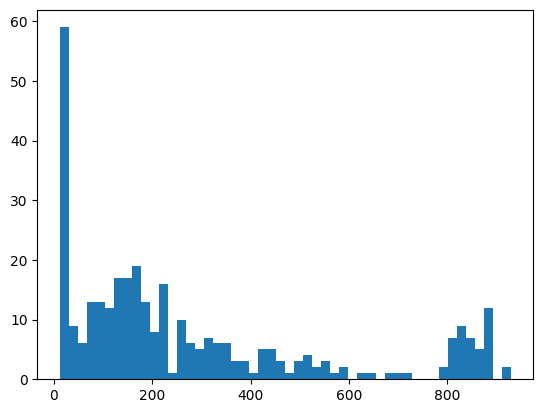

In [41]:

from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
chunk_H5_split = RecursiveCharacterTextSplitter(chunk_size=5000, chunk_overlap=300).split_documents(chunk_H5)
counts(chunk_H5_split)

import matplotlib.pyplot as plt
import numpy as np

plt.hist([len(text.page_content.split()) for text in chunk_H5_split], density=False, bins=50);

# Create the Pinecone database
Initialise the pinecode instance base on the API keys in .env. 

Depending on the user input, use the existing index or create a new one from the documents. Create a "similarity" document retriever based on the database.

In [12]:
from langchain.vectorstores import Pinecone
import pinecone 
import os

def create_namespace(namespace, documents, embeddings):
    
    INDEX = os.environ.get('INDEX')
    
    if INDEX not in pinecone.list_indexes():
        print(f"Creating new index {INDEX}")
        pinecone.create_index(INDEX, dimension=1536)
    
    pinecone.Index(INDEX).delete(namespace=namespace, deleteAll=True)
    
    return Pinecone.from_documents(documents, embeddings, index_name=INDEX, namespace=namespace)

/home/kmcisaac/Projects/Personal/ICWA/.venv/lib/python3.9/site-packages/pinecone/index.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [13]:

from langchain.embeddings.openai import OpenAIEmbeddings

pinecone.init(
    api_key= os.environ.get('PINECONE_API_KEY') ,  # find at app.pinecone.io
    environment=os.environ.get('PINECONE_ENV')     # next to api key in console
)

embeddings = OpenAIEmbeddings()

In [42]:
db5 = create_namespace("SCA_H5", chunk_H5_split, embeddings)

# Create and test the Alice

Define a Q&A chain that 'stuffs' the retrieved chunks into the prompt to provide context. Using OpenAI deterministic (temperature=0) model `gpt-3.5-turbo`.  According to OpenAI 'gpt-3.5-turbo' is the 
> Most capable GPT-3.5 model and optimized for chat at 1/10th the cost of text-davinci-003.

In [51]:
from langchain.llms import OpenAIChat
from langchain.chains import RetrievalQA

qa = RetrievalQA.from_chain_type(
                    llm=OpenAIChat(temperature=0.0), #, uses 'gpt-3.5-turbo' which is cheaper and better 
                    chain_type="stuff", 
                    retriever=db5.as_retriever(search_type="similarity", search_kwargs={"k":3}), 
                    return_source_documents=True)

In [54]:
from IPython.display import display, Markdown

import textwrap

def wrap_text_preserve_newlines(text, width=110):

    lines = text.split('\n')
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]
    wrapped_text = '\n'.join(wrapped_lines)
    return wrapped_text

def process_llm_response(llm_response, sources=True, content=False):
    display(Markdown(wrap_text_preserve_newlines(llm_response['result'])))
    if sources:
      display(Markdown('\n\nSources:'))
      for source in llm_response["source_documents"]:
        display(Markdown(f"{source.metadata.get('title')}"))
        if content:
          display(Markdown(f'{wrap_text_preserve_newlines(source.page_content)}'))

def Simon(query, sources=True, content=False):
  
  instructions = '''You are an expert in Western Australia "Strata Titles Act" 
                    answering questions from a citizen. Only use information provided to you from the 
                    legislation below. If you do not know say "I do not know"'''
  result = qa({"query": f'{instructions} \n\n {query}'})
  process_llm_response(result, sources=sources, content=content)
  return (result)

In [55]:
result = Simon("What does the legisltation cover", sources=False, content=False)

The Strata Titles Act 1985 provides for a form of subdivision of land referred to as subdivision by a strata
titles scheme, and sets out requirements for that form of subdivision. It also contains provisions about the
governance and operation of strata titles schemes and about strata managers. The legislative framework for the
subdivision of land by a strata titles scheme includes the Planning and Development Act 2005 and the Transfer
of Land Act 1893. There are also various transitional provisions and amendments outlined in the legislation.

In [56]:
result = Simon("When was it enacted", sources=False, content=False)

The Strata Titles Act 1985 was enacted in 1985.

In [60]:
result = Simon("What is common property?", sources=True, content=True)

Common property in a strata titles scheme includes that part of the parcel of land subdivided by the scheme
that does not form part of a lot in the scheme, temporary common property, and those parts of a scheme
building that do not form part of a lot. It does not include any land vested in the Crown under the Planning
and Development Act 2005 section 152 or any dedicated road under the Planning and Development Act 2005 section
168.



Sources:

10.	Common property

10.     Common property

        (1)     The common property in a strata titles scheme is —

        (a)     that part of the parcel of land subdivided by the strata titles scheme that does not form part
of a lot in the strata titles scheme; and

        (b)     temporary common property.

        (2)     The common property includes, for a strata scheme, those parts of a scheme building that do
not form part of a lot.

        (3)     The common property does not include —

        (a)     any land vested in the Crown under the Planning and Development Act 2005 section 152; or

        (b)     any dedicated road under the Planning and Development Act 2005 section 168.

        (4)     If a strata plan identifies an encroachment outside the parcel that is to be controlled and
managed as common property, the encroachment is to be regarded, for this Act, as if it were common property.

        [Section 10 inserted: No. 30 of 2018 s. 83.]

91.	General duty

91.     General duty

        (1)     A strata company must —

        [(a)    deleted]

        (b)     control and manage the common property for the benefit of all the owners of lots; and

        (c)     keep in good and serviceable repair, properly maintain and, if necessary, renew and replace —

        (i)     the common property, including the fittings, fixtures and lifts used in connection with the
common property; and

        (ii)    any personal property owned by the strata company,

                and to do so whether damage or deterioration arises from fair wear and tear, inherent defect
or any other cause.

        [(d)-(k)        deleted]

        (2)     A strata company may improve or alter the common property in a manner that goes beyond what is
required under subsection (1).

        Note for this subsection:

                Expenditure above a certain amount incurred for the purposes set out in subsection (2) must be
authorised by special resolution, except for expenditure on sustainability infrastructure, which may be
authorised by ordinary resolution: see section 102.

        (3)     A strata company may sue and be sued for rights and liabilities related to the common property
in the strata titles scheme as if it were the owner and occupier of the common property.

        [Section 91, formerly section 35, amended: No. 58 of 1995 s. 37, 94 and 95; No. 14 of 1996 s. 4;
amended, renumbered as section 91 and relocated: No. 30 of 2018 s. 47 and 84.]

26.	Long term lease or licence over common property

26.     Long term lease or licence over common property

                A lease or licence, or lease and licence, to use or occupy the common property or part of the
common property, in a strata titles scheme for a term or terms exceeding the period specified in the
regulations in aggregate (including any option to extend or renew the term of a lease or licence) is not
effective unless it has been approved in writing by the local government of the district in which the parcel
is situated.

        [Section 26 inserted: No. 30 of 2018 s. 83.]

[Former section 26 renumbered as section 28 and relocated to Part 3 Division 4: No. 30 of 2018 s. 84.]

# Experimental 

This is not yet working

In [ ]:

from langchain.chains.question_answering import load_qa_chain
from langchain.chains import AnalyzeDocumentChain
from langchain.chat_models import ChatOpenAI


qa_chain = load_qa_chain(llm=ChatOpenAI(temperature=0.0), #, uses 'gpt-3.5-turbo' which is cheaper and better 
                         chain_type="map_reduce")

qa_document_chain = AnalyzeDocumentChain(combine_docs_chain=qa_chain)
doc =  docx.Document(legislation_path)
text_doc = "\n\n".join([para.text for para in doc.paragraphs])
qa_document_chain.run(input_document=text_doc, question="What is the purpose of this legislation")